# ASAP 2.0 analyses

Find optimal hyperparameters on the ASAP 2.0 dataset using ModernBERT

This is the reduced dataset (contains none of the PERSUADE essays)

In [19]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
from scipy import stats
from IPython.display import display
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    DefaultDataCollator
)
import wandb # Weights and Biase

model_id = "answerdotai/ModernBERT-large"
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Replace the variables below with your own: name, project name, and project directory
%env WANDB_PROJECT = asap
%env WANDB_DIR = bin
%env WANDB_NOTEBOOK_NAME = asap_llm_modeling_modernbert.ipynb

env: WANDB_PROJECT=asap
env: WANDB_DIR=bin
env: WANDB_NOTEBOOK_NAME=asap_llm_modeling_modernbert.ipynb


## Configure Logging

In [20]:
from transformers import logging
logging.set_verbosity_error()
%env WANDB_SILENT = true

env: WANDB_SILENT=true


## Load and Prepare ASAP Corpus

In [22]:
asap_df = pd.read_csv("data/ASAP2_new_IN_data_only_w_splits.csv")
asap_df['text'] = asap_df['full_text']+tokenizer.sep_token+asap_df['assignment']
asap_df.sample(2)

,essay_id,score,full_text,set,pubpriv,assignment,prompt_name,economically_disadvantaged,student_disability_status,ell_status,race_ethnicity,gender,grade_level,essay_word_count,source,task,stratified_split,text
8169,AAATRP14318000364261,4,School is a place where students go to learn. ...,test,public,"In the article ""Making Mona Lisa Smile,"" the a...",Facial action coding system,Not economically disadvantaged,Not identified as having disability,No,Hispanic/Latino,M,10,493.0,MI,Text dependent,test,School is a place where students go to learn. ...
900,AAAOPP13416000025057,5,"""Driverless Cars Are Coming!"" ""Television and ...",test,private,"In the article “Driverless Cars are Coming,” t...",Driverless cars,Not economically disadvantaged,Not identified as having disability,No,Hispanic/Latino,F,10,589.0,MI,Text dependent,train,"""Driverless Cars Are Coming!"" ""Television and ..."


In [23]:
asap_df_clean = (
    asap_df[['text', 'score', 'stratified_split']]
    .rename(
        columns={
            'full_text': 'text',
            'score': 'label',
        }
    )
    .assign(label=lambda df: df.label.astype('float'))
    .reset_index(drop=True)
)

asap_df_clean.sample(2)

,text,label,stratified_split
9216,Being able to read a students emotinal express...,3.0,test
8934,Modern technology is a magnificant tool to us....,3.0,train


## Simple word count

In [24]:
asap_df_clean.text.str.split().str.len().describe()

count    11825.000000
mean       420.998562
std        137.231074
min        204.000000
25%        315.000000
50%        398.000000
75%        501.000000
max       1283.000000
Name: text, dtype: float64

## Check for missing data

In [25]:
print(asap_df_clean.info())
asap_df_clean=asap_df_clean.dropna(how='any')
print(asap_df_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11826 entries, 0 to 11825
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   text              11825 non-null  object 
 1   label             11826 non-null  float64
 2   stratified_split  11826 non-null  object 
dtypes: float64(1), object(2)
memory usage: 277.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 11825 entries, 0 to 11825
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   text              11825 non-null  object 
 1   label             11825 non-null  float64
 2   stratified_split  11825 non-null  object 
dtypes: float64(1), object(2)
memory usage: 369.5+ KB
None


### Get training and test sets

These are already defined in the datasets. Just need to divide and name them

This is with a validation set used for hyperparameters

Training and test sets would be different and found underset.



In [26]:
# What's in there?

sets = asap_df_clean['stratified_split'].unique()
print(sets)

['train' 'test' 'dev']


In [27]:
asap_dd = DatasetDict({
    "train": Dataset.from_pandas(asap_df_clean[asap_df_clean["stratified_split"] == "train"].reset_index(drop=True)),
    # Use a subsample to validate the notebook:
    # "train": Dataset.from_pandas(
    #     asap_df_clean[asap_df_clean["pubpriv"] == "0"]
    #     .reset_index(drop=True)
    #     .sample(200)
    # ),
    "dev": Dataset.from_pandas(asap_df_clean[asap_df_clean["stratified_split"] == "dev"].reset_index(drop=True)),
    "test": Dataset.from_pandas(asap_df_clean[asap_df_clean["stratified_split"] == "test"].reset_index(drop=True)),
})
asap_dd

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'stratified_split'],
        num_rows: 5912
    })
    dev: Dataset({
        features: ['text', 'label', 'stratified_split'],
        num_rows: 2956
    })
    test: Dataset({
        features: ['text', 'label', 'stratified_split'],
        num_rows: 2957
    })
})

### Pre-process inputs (tokenization)


In [28]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [29]:
def tokenize_inputs(example):
    return tokenizer(example['text'])

In [30]:
asap_dd_tokenized = asap_dd.map(tokenize_inputs, batched=True, remove_columns=['text'])

Map:   0%|          | 0/5912 [00:00<?, ? examples/s]

Map:   0%|          | 0/2956 [00:00<?, ? examples/s]

Map:   0%|          | 0/2957 [00:00<?, ? examples/s]

In [31]:
asap_dd_tokenized['train']

Dataset({
    features: ['label', 'stratified_split', 'input_ids', 'attention_mask'],
    num_rows: 5912
})

### Data Collator
A data collator feeds the data to the language model. [More information](https://huggingface.co/course/chapter3/2?fw=pt).




In [32]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [33]:
def model_init(config):
    return AutoModelForSequenceClassification.from_pretrained(
        model_id,
        num_labels=1, # Regression
        # pooler_dropout=config.pooler_dropout
    )

### Define Metrics

In [34]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    return {"mse": mean_squared_error(logits, labels)}

### Hyperparameter Optimization

Config is based on hyperparameters used in benchmark tasks in Warner et al. (2024):
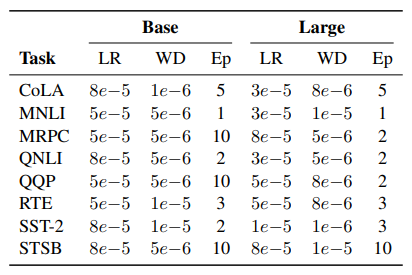

In [36]:
sweep_config = {
    'name': 'deberta-v3-large',
    'method': 'bayes', #bayes
    'run_cap': 42, # bayesian optimizer will run until stopped if this is not set
    'metric': {
        'name': f'eval/mse', # mean squared error
        'goal': 'minimize'}, # we want to "minimize" the mean squared error.
    'parameters': {
        'batch_size': {'value': 12}, # We will use the recommended batch size of 12
        # 'gradient_accumulation_steps': {'values': [16, 32, 64]},
        'learning_rate': {'values':  [1e-5, 3e-5, 5e-5, 8e-5]},
        'num_train_epochs': {'values': [1, 2, 3, 5, 10]}, 
        # 'pooler_dropout': {'values': [0, 0.15, 0.30]}, #Dropout is a regularization technique used to prevent overfitting by randomly setting a fraction of the input units to 0 during training
        'weight_decay': {'values':  [1e-6, 5e-6, 8e-6, 1e-5]}, #hyperparameter that controls the L2 regularization applied to the model's weights during training. L2 regularization is a common technique used to prevent overfitting by adding a penalty term to the loss function, proportional to the square of the model's weights
    },
}

In [37]:
def train():
    with wandb.init():
        # set sweep configuration
        config = wandb.config

        # Customize the trainer
        training_args = TrainingArguments(
            output_dir = 'bin', 
            optim = 'adamw_torch', # Specify your optimizer
            logging_dir = 'logs', 
            load_best_model_at_end = False, # Do not load the best model at the end
            metric_for_best_model = 'mse', # We will be using mean squared error to evaluate model performance
            evaluation_strategy='epoch', # Evaluate model performance at the end of each epoch
            save_strategy='no', # checkpoints are saved after each epoch 
            greater_is_better = False, # mse likes lower
            log_level = 'error', # only error-level messages will be logged
            disable_tqdm = False, # show progress bar
            report_to='wandb',
            # The hyper parameters we are tuning (number of epochs, learning rate, and batch size)
            # are called in from the configuration dictionary
            num_train_epochs=config.num_train_epochs,
            learning_rate=config.learning_rate,
            per_device_train_batch_size=config.batch_size,
            per_device_eval_batch_size=16,
        )

        model = model_init(config)

        # Initialize the trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=asap_dd_tokenized['train'],
            eval_dataset=asap_dd_tokenized['dev'],
            compute_metrics=compute_metrics,
            tokenizer=tokenizer,
        )


        # Start training loop
        trainer.train()

In [ ]:
sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id, train)

Create sweep with ID: cnqh31pg
Sweep URL: https://wandb.ai/ai-aloe/asap/sweeps/cnqh31pg


/home/jovyan/conda_envs/wes-env2/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_2333/102503344.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Mse
1,No log,0.319354,0.319354
2,0.488300,0.292116,0.292116
3,0.302600,0.308285,0.308285
4,0.208200,0.328266,0.328266
5,0.105200,0.297533,0.297533
6,0.057300,0.293257,0.293257
7,0.037100,0.292246,0.292246
8,0.020600,0.286885,0.286885
9,0.010100,0.287948,0.287948


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



/home/jovyan/conda_envs/wes-env2/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_2333/102503344.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
